<a href="https://colab.research.google.com/github/dhwanigupta18/image-caption/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q transformers==4.30.2
!pip install -q accelerate
!pip install -q Pillow

In [3]:
import torch
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import requests

# Set device to GPU if available, otherwise CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load BLIP processor and model
# This will download the pre-trained weights, which might take a few minutes.
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

print("BLIP model loaded successfully!")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

BLIP model loaded successfully!


Image from URL loaded successfully!


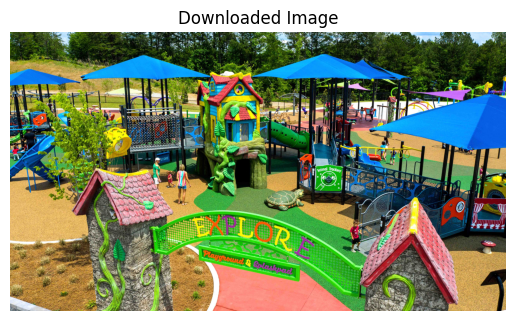

In [6]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Example image URL
# Let's try the original URL first, as it often works.
img_url = 'https://mrcrec.com/hs-fs/hubfs/Imported_Blog_Media/49717981617_b352f631a6_o.jpg'

try:
    # Send a GET request to the image URL
    response = requests.get(img_url)
    response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)

    # Use BytesIO to wrap the content of the response.
    # This ensures Pillow receives a file-like object with the complete image data.
    image_bytes = BytesIO(response.content)

    # Open the image using Pillow
    raw_image = Image.open(image_bytes).convert('RGB')
    print(f"Image from URL loaded successfully!")

    # Display the image to confirm
    plt.imshow(raw_image)
    plt.axis('off')
    plt.title("Downloaded Image")
    plt.show()

except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")
    print(f"Please check the URL: {img_url}")
except Image.UnidentifiedImageError as e:
    print(f"Error: Could not identify image file. The URL might not point to a valid image.")
    print(f"Details: {e}")
    print(f"Tried to open: {img_url}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

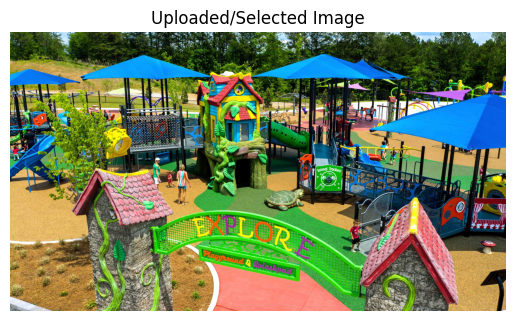

In [7]:
import matplotlib.pyplot as plt

plt.imshow(raw_image)
plt.axis('off')
plt.title("Uploaded/Selected Image")
plt.show()

In [8]:
# Prepare the image for the model
inputs = processor(raw_image, return_tensors="pt").to(device)

# Generate the caption
# You can adjust parameters like max_new_tokens for longer/shorter captions,
# and num_beams for better quality (but slower inference).
generated_ids = model.generate(**inputs, max_new_tokens=20, num_beams=5) # Example: max_new_tokens=20, num_beams=5

# Decode the generated IDs to a natural language string
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

print(f"\nGenerated Caption: {generated_caption}")


Generated Caption: a children's play area in a park


In [11]:
from IPython.display import display, Javascript
from ipywidgets import FileUpload, Button, Output
from PIL import Image
import io
import matplotlib.pyplot as plt

# Ensure BLIP processor and model are loaded and on device
# (You would have run these from previous steps)
# processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
# model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def create_captioning_interface():
    upload_button = FileUpload(
        accept='image/*',
        multiple=False
    )
    generate_button = Button(description="Generate Caption")
    output_area = Output() # This will capture print statements and plot outputs

    # Crucially, display the widgets
    display(upload_button, generate_button, output_area)

    def on_generate_click(b):
        with output_area: # Direct output to this widget
            output_area.clear_output() # Clear previous output each time
            if not upload_button.value:
                print("Please upload an image first.")
                return

            try:
                # Get the uploaded image
                uploaded_file = list(upload_button.value.values())[0]
                image_bytes = uploaded_file['content']
                raw_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

                print("Image uploaded. Generating caption...")
                plt.imshow(raw_image)
                plt.axis('off')
                plt.title("Uploaded Image")
                plt.show() # Make sure to show the plot

                # Prepare image for the model
                # Ensure 'processor' and 'model' are in scope (loaded in previous cells)
                inputs = processor(raw_image, return_tensors="pt").to(device)

                # Generate the caption
                generated_ids = model.generate(**inputs, max_new_tokens=20, num_beams=5)
                generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

                print(f"\nGenerated Caption: {generated_caption}")

            except Exception as e:
                print(f"An error occurred during caption generation: {e}")

    generate_button.on_click(on_generate_click)

# Call the function to create the interface
create_captioning_interface()

FileUpload(value={}, accept='image/*', description='Upload')

Button(description='Generate Caption', style=ButtonStyle())

Output()